# OSMnx Library Introduction

---

## Import the library and make a first example

In the next code space I just import the OSMnx library and in the next code space you can find the first example on how to use OSMnx.

In [4]:
# Importing the useful libraries

import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps as cmaps

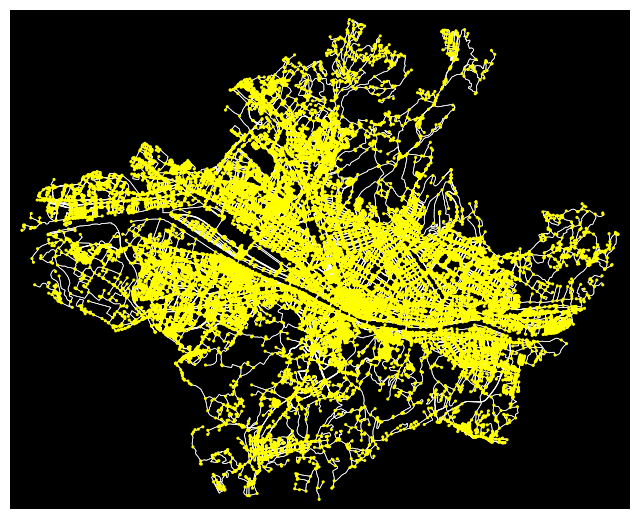

In [2]:
# Searches on OpenStreetMap the place it indicates (in this case "Florence, Italy"),
# downloads the road network of that area,
# builds a graph where:
# - the nodes are intersections, points of interest, etc.
# - the edges are the road segments that connect the nodes.
# - walk = walkable streets

graph = ox.graph_from_place("Florence, Italy", network_type="walk")

fig, ax = ox.plot_graph(
    graph,
    node_color='yellow',
    node_size=5,
    edge_color='white',
    edge_linewidth=0.5,
    bgcolor='black'
)

---

## Another example, let's try to get some K-th Shortest Path

In the next code lines we can figure out how to calculate the k-th shortest path between two places in a specific city.

In [2]:
# Generate MultiIndex (u, v, key) for edges in a path
def generate_multiindex(route_nodes):
    return [(u, v, 0) for u, v in zip(route_nodes[:-1], route_nodes[1:])]

# Load the map data
place = "Piedmont, California, USA"
G = ox.graph_from_place(place, network_type="drive")
G = ox.project_graph(G)

# Define origin and destination nodes
orig = list(G)[0]
dest = list(G)[140]

# Number of shortest paths
k = 10
routes_nodes = list(ox.routing.k_shortest_paths(G, orig, dest, k=k, weight="length"))

# Convert graph to GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# Get a rainbow colormap and extract k colors
cmap = cmaps["rainbow"]
colors_list = [mcolors.rgb2hex(cmap(i / k)) for i in range(k)]  # Scale i/k to get k distinct colors

# Extract and color edges for each route
colored_routes = []
for i, route in enumerate(routes_nodes):
    idx = generate_multiindex(route)
    edges = gdf_edges[gdf_edges.index.isin(idx)].copy()
    edges["color"] = colors_list[i]
    colored_routes.append(edges)

# Combine all colored route edges
all_routes = pd.concat(colored_routes)
all_routes_gdf = gpd.GeoDataFrame(all_routes)

# Plot using assigned colors
all_routes_gdf.explore(color=all_routes_gdf["color"])

---

## Now let's manage some advanced tests for OSMnx

## Test 1: Download and plot walking network graph for Turin, Italy
This test downloads the walkable street network of Turin from OpenStreetMap, and plots the graph highlighting nodes and edges.

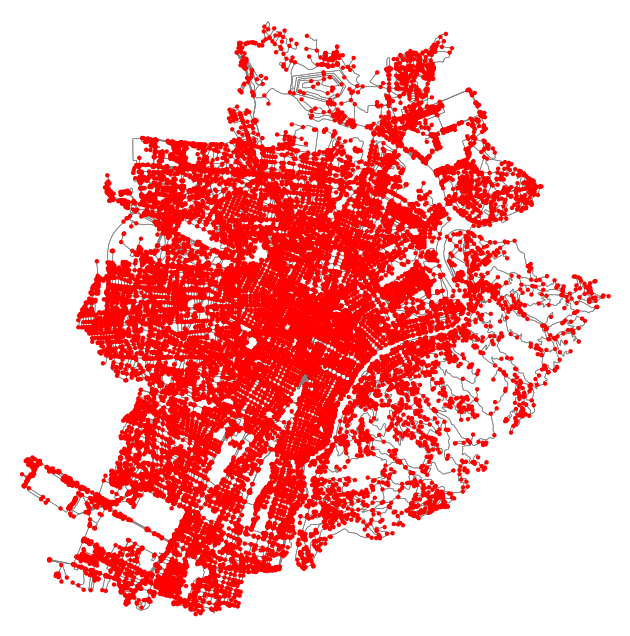

In [14]:
place = "Turin, Italy"
G = ox.graph_from_place(place, network_type="walk")

# Plot the graph with customized node and edge colors and sizes
fig, ax = ox.plot_graph(
    G,
    node_size=10,
    node_color='red',
    edge_color='gray',
    edge_linewidth=0.5,
    bgcolor='white'
)

## Test 2: Compute and print basic graph statistics
This test extracts useful statistics such as number of nodes and edges, average degree, density, and other network metrics to understand the graph structure.

In [15]:
stats = ox.basic_stats(G)

print("Basic statistics of Turin walking network:")
for stat_name, stat_value in stats.items():
    print(f"{stat_name}: {stat_value}")

Basic statistics of Turin walking network:
n: 30362
m: 89928
k_avg: 5.923720440023714
edge_length_total: 4892636.744688186
edge_length_avg: 54.406155420872096
streets_per_node_avg: 2.9706211712008432
streets_per_node_counts: {0: 0, 1: 4484, 2: 0, 3: 18037, 4: 7635, 5: 178, 6: 27, 7: 1}
streets_per_node_proportions: {0: 0.0, 1: 0.1476846057571965, 2: 0.0, 3: 0.5940649496080627, 4: 0.25146564784928527, 5: 0.005862591397141163, 6: 0.0008892694815888281, 7: 3.293590672551215e-05}
intersection_count: 25878
street_length_total: 2446318.372344118
street_segment_count: 44964
street_length_avg: 54.40615542087266
circuity_avg: 1.0708209216419649
self_loop_proportion: 0.002379681522996175


## Test 3: Project the graph to UTM coordinates

OSMnx graphs are initially in latitude and longitude (WGS84).

To perform accurate distance and metric calculations, we project to the Universal Transverse Mercator (UTM) coordinate reference system.

In [16]:
G_proj = ox.project_graph(G)

## Test 4: Calculate and plot the shortest path between two nodes
Using NetworkX shortest_path function with edge length as weight, this test finds the shortest route (in meters) between two sample nodes, and visualizes it on the projected graph.

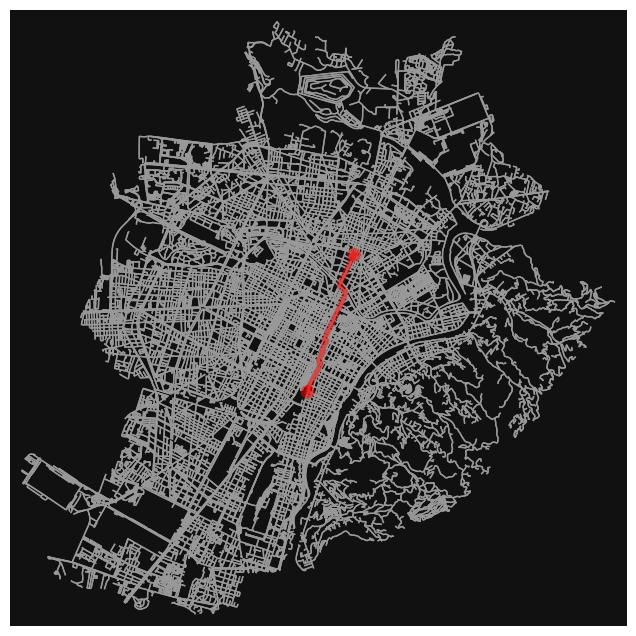

In [17]:
import networkx as nx

orig_node = list(G_proj.nodes())[0]
dest_node = list(G_proj.nodes())[100]

# Compute shortest path by length (meters)
route = nx.shortest_path(G_proj, orig_node, dest_node, weight='length')

# Plot graph with route highlighted
fig, ax = ox.plot_graph_route(G_proj, route, route_linewidth=4, node_size=0)

## Test 5: Analyze node degree distribution and plot histogram
Node degree represents the number of connections per node.

This test calculates degrees for all nodes and plots their frequency distribution, showing connectivity characteristics of the walking network.

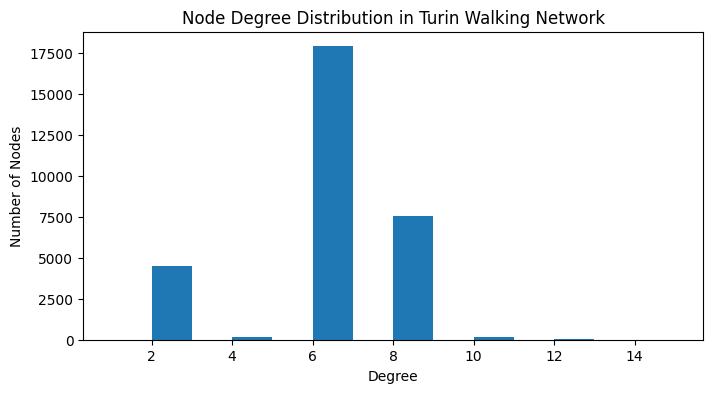

In [18]:
degrees = dict(G_proj.degree())
degree_values = list(degrees.values())

plt.figure(figsize=(8,4))
plt.hist(degree_values, bins=range(1, max(degree_values)+2))
plt.title("Node Degree Distribution in Turin Walking Network")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()

## Test 6: Calculate and plot edge length distribution

We calculate lengths of all edges in the graph, and plot a histogram to understand the distribution of street segment lengths.

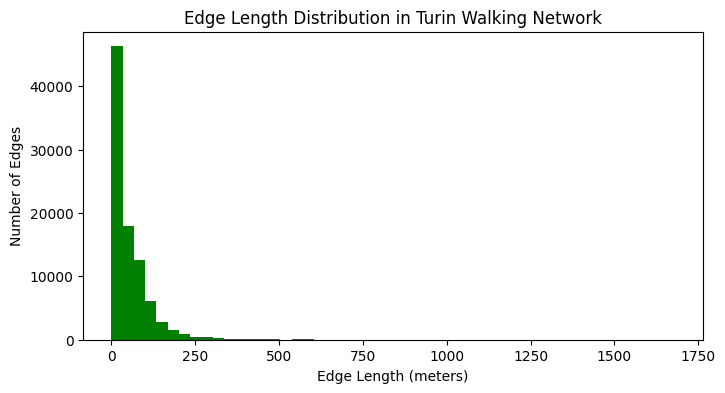

In [22]:
edge_lengths = [data['length'] for u, v, data in G_proj.edges(data=True)]

plt.figure(figsize=(8,4))
plt.hist(edge_lengths, bins=50, color='green')
plt.title("Edge Length Distribution in Turin Walking Network")
plt.xlabel("Edge Length (meters)")
plt.ylabel("Number of Edges")
plt.show()

## Test 7: Calculate average street segment length and total network length

This test computes the average edge length and total length of all edges to understand the granularity and extent of the network.

In [23]:
import numpy as np

avg_length = np.mean(edge_lengths)
total_length = np.sum(edge_lengths)

print(f"Average edge length: {avg_length:.2f} meters")
print(f"Total network length: {total_length:.2f} meters")

Average edge length: 54.41 meters
Total network length: 4892636.74 meters


## Test 8: Calculate network statistics and connectivity measures

We use `ox.basic_stats` to explore network-level statistics and assess how well-connected the street network is. Since the key `'edge_density_km'` is no longer available in the latest versions of OSMnx, we rely on other structural metrics such as the number of nodes, edges, intersections, and average degree.

In [27]:
# Compute basic statistics on the projected graph
stats_simple = ox.basic_stats(G_proj)

# Print key network metrics
print("Turin's network statistics:")
print(f"Number of nodes: {stats_simple['n']}")
print(f"Number of edges: {stats_simple['m']}")
print(f"Average node degree: {stats_simple['k_avg']:.2f}")
print(f"Total edge length (meters): {stats_simple['edge_length_total']:.2f}")
print(f"Average edge length (meters): {stats_simple['edge_length_avg']:.2f}")
print(f"Average streets per node: {stats_simple['streets_per_node_avg']:.2f}")
print(f"Number of intersections: {stats_simple['intersection_count']}")
print(f"Average circuity: {stats_simple['circuity_avg']:.2f}")

Turin's network statistics:
Number of nodes: 30362
Number of edges: 89928
Average node degree: 5.92
Total edge length (meters): 4892636.74
Average edge length (meters): 54.41
Average streets per node: 2.97
Number of intersections: 25878
Average circuity: 1.07


---